In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [2]:
kora_seg_paths = glob.glob('/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_segs/ROI_liver_spleen_Daniel/**/comp_mask.nii')
print(len(kora_seg_paths))
is_processed_labels = False

367


In [ ]:
kora_seg_paths = glob.glob('/home/abhijit/Jyotirmay/my_thesis/dataset_groups/whole_body_datasets/KORA/processed_data/labels/**')
print(len(kora_seg_paths))
is_processed_labels = True

In [3]:
sample_count_dict = {}
for r_id, sample in enumerate(kora_seg_paths):
    print("\rProcessing {}/{}.".format(r_id, len(kora_seg_paths)), end="")
    if is_processed_labels:
        v_id = sample.split('/')[-1].split('.')[0]
    else:
        v_id = sample.split('/')[-2]

    s_data = nb.load(sample).get_fdata()
    unique_vals, counts = np.unique(s_data, return_counts=True)
    if len(counts) is not 3:
        print('not all class present, skipping!!')
        continue
    if v_id not in sample_count_dict.keys():
        sample_count_dict[v_id] = {}

    sample_count_dict[v_id]['seg_spleen'] = counts[2]
    sample_count_dict[v_id]['seg_liver'] = counts[1]


print(sample_count_dict)
df = pd.DataFrame.from_dict(sample_count_dict, orient="index")
df.to_csv(f'{is_processed_labels}sample_count_report.csv', index_label='volume_id')
df

Processing 70/367.not all class present, skipping!!
Processing 127/367.not all class present, skipping!!
Processing 192/367.not all class present, skipping!!
Processing 366/367.{'KORA2406152': {'seg_spleen': 379460, 'seg_liver': 48834}, 'KORA2406532': {'seg_spleen': 410671, 'seg_liver': 68303}, 'KORA2452036': {'seg_spleen': 415225, 'seg_liver': 45590}, 'KORA2452050': {'seg_spleen': 236339, 'seg_liver': 28536}, 'KORA2452094': {'seg_spleen': 648444, 'seg_liver': 46749}, 'KORA2452118': {'seg_spleen': 359418, 'seg_liver': 38702}, 'KORA2452129': {'seg_spleen': 300057, 'seg_liver': 38689}, 'KORA2452146': {'seg_spleen': 334234, 'seg_liver': 70691}, 'KORA2452162': {'seg_spleen': 379455, 'seg_liver': 66810}, 'KORA2452190': {'seg_spleen': 456048, 'seg_liver': 39487}, 'KORA2452206': {'seg_spleen': 210034, 'seg_liver': 35749}, 'KORA2452252': {'seg_spleen': 297286, 'seg_liver': 35765}, 'KORA2452263': {'seg_spleen': 298806, 'seg_liver': 29915}, 'KORA2452274': {'seg_spleen': 439276, 'seg_liver': 6856

,seg_spleen,seg_liver
KORA2406152,379460,48834
KORA2406532,410671,68303
KORA2452036,415225,45590
KORA2452050,236339,28536
KORA2452094,648444,46749
KORA2452118,359418,38702
KORA2452129,300057,38689
KORA2452146,334234,70691
KORA2452162,379455,66810
KORA2452190,456048,39487


In [4]:
df = pd.read_csv(f'{is_processed_labels}sample_count_report.csv')
df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')

In [5]:
df_merged = pd.merge(df, df_k_feats, how='inner', on=['volume_id'])
df_merged.to_csv(f'{is_processed_labels}concat_report_final.csv')
df = pd.read_csv(f'{is_processed_labels}concat_report_final.csv')

In [9]:
good_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
             'hba1c-mmol/mol', 'cholesterol-hdl', 'age', 'blood-pressure-diastolic', 'blood-pressure-systolic',
             'sex', 'bmi-numeric']

smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non-smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi-numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight' ]
vols_feat = ['seg_liver', 'seg_spleen']

In [27]:
is_processed_labels = True
df = pd.read_csv(f'{is_processed_labels}concat_report_final.csv')

In [28]:
categorical_features = ['diabetes_status']
for f in categorical_features:
    dfDummies = pd.get_dummies(df[f], prefix = f)
    df_c = pd.concat([df, dfDummies], axis=1)

In [29]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [30]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_spleen"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,2375.008706,1.018146e-159
height,805.370323,1.806350e-206
sex,151228.927374,2.435294e-74
weight,1657.847259,7.262960e-250
smoker_former,141784.653846,1.624121e-38
smoker_irregular,137255.416667,7.268815e-04
smoker_non-smoker,130733.228814,3.739747e-28
smoker_regular,143439.500000,2.785079e-13
smoking-packages,3948.838130,6.796748e-29
bmi-who_normal,114945.765432,2.286045e-14


In [31]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_liver"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         print(X)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,306.650493,7.207508e-115
height,104.058202,5.137081e-133
sex,20169.474860,2.080037e-69
weight,215.290671,1.642619e-148
smoker_former,19594.861538,4.301031e-40
smoker_irregular,18457.000000,8.403236e-04
smoker_non-smoker,16684.932203,2.333312e-24
smoker_regular,15051.125000,3.164230e-08
smoking-packages,497.978912,2.564512e-24
bmi-who_normal,14300.185185,4.423222e-12


In [32]:
mod_s = []
all_feats_simple = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight']]
all_feats_simple1 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['bmi-numeric']]
all_feats_simple2 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight', 'bmi-numeric']]
all_feats_simple3 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]
for feats_list in [all_feats_simple1]:
    feats = flatten(feats_list)
    df_c = df_c.fillna(0)
    p_values = {}
    for target in ['seg_liver', 'seg_spleen']:
        print(target)
        for i in range(2):
            
            y = df_c[target].copy()
    #         print(y.values)
    #         y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
            y_classes = y.values
            if i==0:
                continue
                print('iou as multiplier')
                target_prefix = target.split('_')[1]
                ious = df_c['iou_'+target_prefix].values
#                 print(y_classes[0:10], ious[0:10])
                y_classes = np.multiply(y_classes, ious)
#                 print(y_classes[0:10])
    #         print(y_classes)
            try:
                print(feats)
                X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
            #         X = X.fillna(0)
                mod = sm.OLS(y_classes, X)
                mod_ = ols("y_classes ~ X", df_c).fit()
                mod_s.append(mod_)
                table = sm.stats.anova_lm(mod_) # Type 2 Anova DataFrame
                print('------------------------------------------------------------')
                print(table)
                fii = mod.fit()
                print(fii.summary())
                df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#                 print(df_fii)
            #         print(f, fii.pvalues.values[0], fii.params.values)
                p_values[f] = {'coeff': fii.params.values, 'p_value':fii.pvalues.values}
            except Exception as e:
                print(e)

# full_table = sm.stats.anova_lm(mod_s) # Type 2 Anova DataFrame
# print(full_table)
# print(p_values)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df

seg_liver
['age', 'sex', 'diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2', 'bmi-numeric']
------------------------------------------------------------
             df        sum_sq       mean_sq         F        PR(>F)
X           6.0  4.389910e+09  7.316517e+08  16.62085  1.446534e-16
Residual  302.0  1.329407e+10  4.402011e+07       NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     19.72
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           5.23e-17
Time:                        15:00:20   Log-Likelihood:                -3144.4
No. Observations:                 308   AIC:                             6301.
Df Residuals:                     302   BIC:                             6323.


In [33]:
df_c.rename(columns={'bmi-numeric':'bmi_numeric'}, 
                 inplace=True)

In [34]:
mod_liver = ols('seg_liver ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()
mod_spleen = ols('seg_spleen ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()

In [35]:
full_table = sm.stats.anova_lm(mod_liver) # Type 2 Anova DataFrame
print(full_table)

                      df        sum_sq       mean_sq          F        PR(>F)
age                  1.0  8.833874e+07  8.833874e+07   2.006781  1.576279e-01
sex                  1.0  2.543325e+09  2.543325e+09  57.776418  3.729555e-13
bmi_numeric          1.0  1.697787e+09  1.697787e+09  38.568426  1.746635e-09
diabetes_status_0    1.0  1.167455e+07  1.167455e+07   0.265209  6.069403e-01
diabetes_status_1    1.0  9.783528e+04  9.783528e+04   0.002223  9.624300e-01
diabetes_status_2    1.0  7.201838e+07  7.201838e+07   1.636033  2.018525e-01
Residual           302.0  1.329407e+10  4.402011e+07        NaN           NaN


In [36]:
full_table = sm.stats.anova_lm(mod_spleen) # Type 2 Anova DataFrame
print(full_table)

                      df        sum_sq       mean_sq           F        PR(>F)
age                  1.0  1.179466e+10  1.179466e+10   23.976001  1.591704e-06
sex                  1.0  7.868111e+10  7.868111e+10  159.941741  1.041389e-29
bmi_numeric          1.0  9.370240e+10  9.370240e+10  190.476788  6.257635e-34
diabetes_status_0    1.0  7.876555e+09  7.876555e+09   16.011339  7.926977e-05
diabetes_status_1    1.0  6.677525e+09  6.677525e+09   13.573969  2.717270e-04
diabetes_status_2    1.0  6.770972e+08  6.770972e+08    1.376393  2.416410e-01
Residual           302.0  1.485647e+11  4.919361e+08         NaN           NaN


In [37]:
df_normal = df[df['diabetes_status']==0]
df_pre_diabetic = df[df['diabetes_status']==1]
df_diabetic = df[df['diabetes_status']==2]

In [38]:
df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


normal_seg_spleen vs pre_diabetic_seg_spleen
t: -4.738713473030894
p: 3.5060629141588167e-06


normal_seg_spleen vs diabetic_seg_spleen
t: -7.172708062833062
p: 9.33633408318639e-12


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 2.719398302668019
p: 0.007632988156583453


normal_seg_liver vs pre_diabetic_seg_liver
t: -2.7320392269522236
p: 0.006715818842019691


normal_seg_liver vs diabetic_seg_liver
t: -2.686697407737097
p: 0.007727116674720063


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.5847595083100523
p: 0.5599404661887748




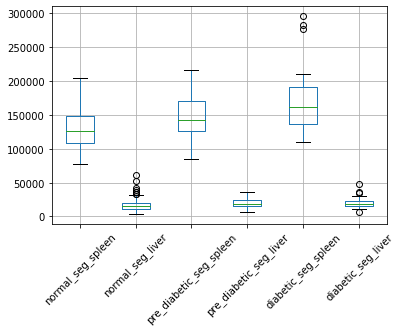

In [39]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')